# PPG Pipeline

In [1]:
# Imports
import os, math, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

RAW_PATH = "../data/raw/PPG_dataset.csv"
FIG_DIR = "../reports/figures/ppg_before cleaning/"
FIG_DIR_AFTER = "../reports/figures/ppg_after cleaning/"
FIG_DIR_TRAIN = "../reports/figures/ppg_training/"
OUT_FUSION = "../data/processed/ppg_with_embeddings.csv"
os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(FIG_DIR_AFTER, exist_ok=True)
os.makedirs(FIG_DIR_TRAIN, exist_ok=True)
os.makedirs("../data/processed", exist_ok=True)

In [2]:
# Load data
df_raw = pd.read_csv(RAW_PATH)
print("Shape:", df_raw.shape)
print("Columns sample:", df_raw.columns[:10].tolist())

# waveform columns are strings "0"..."1999"
wave_cols = [c for c in df_raw.columns if c.isdigit()]
wave_cols = sorted(wave_cols, key=lambda x: int(x))
print("Waveform length:", len(wave_cols))

labels = df_raw["Label"] if "Label" in df_raw.columns else None

Shape: (2576, 2001)
Columns sample: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
Waveform length: 2000


# Visualization of raw waveforms

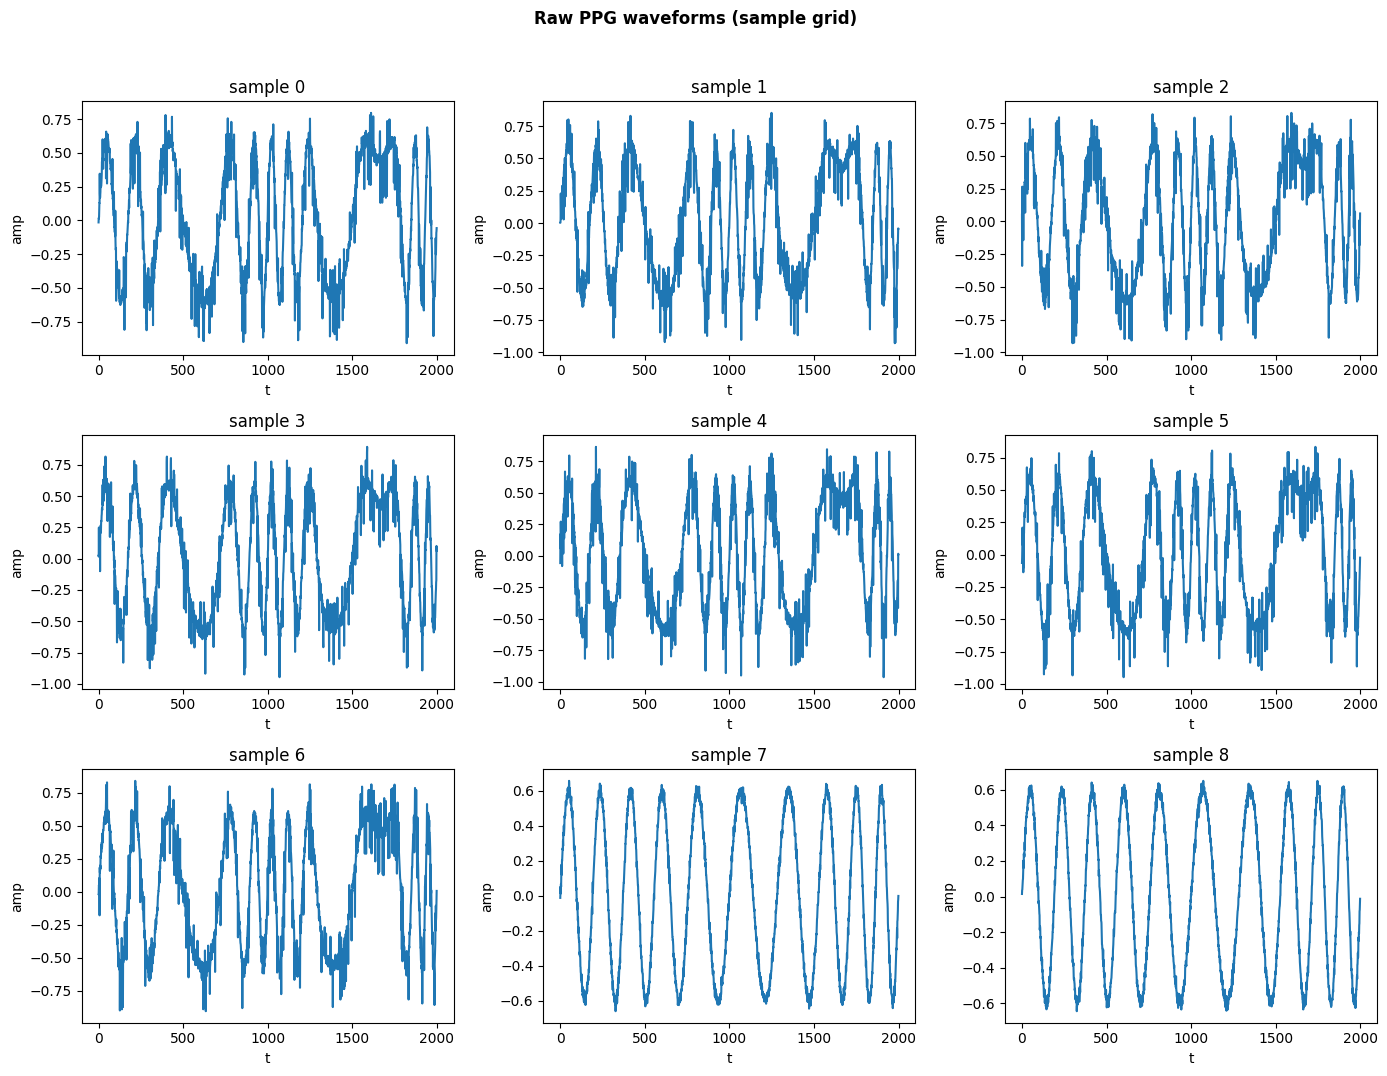

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def plot_wave_grid(X, title, save_path, n=9):
    n = min(n, X.shape[0])
    ncols = 3
    nrows = math.ceil(n / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(14, 3.5*nrows))
    axes = axes.flatten()

    for i in range(n):
        axes[i].plot(X[i])
        axes[i].set_title(f"sample {i}")
        axes[i].set_xlabel("t")
        axes[i].set_ylabel("amp")
    for j in range(i+1, len(axes)):
        axes[j].axis("off")

    fig.suptitle(title, y=1.02, fontweight="bold")
    plt.tight_layout()
    fig.savefig(save_path, dpi=150, bbox_inches="tight")
    plt.show()

X_raw = df_raw[wave_cols].apply(pd.to_numeric, errors="coerce").values.astype(float)
X_raw = np.nan_to_num(X_raw, nan=0.0, posinf=0.0, neginf=0.0)

plot_wave_grid(X_raw, "Raw PPG waveforms (sample grid)", os.path.join(FIG_DIR, "waveforms_raw_grid.png"))

# Preprocessing Waveforms

In [4]:
from scipy.signal import butter, filtfilt, detrend, welch

FS = 100 # Hz
LOW, HIGH = 0.5, 8.0  # Hz

def bandpass(sig, fs=FS, low=LOW, high=HIGH, order=4):
    nyq = 0.5 * fs
    b, a = butter(order, [low/nyq, high/nyq], btype="band")
    return filtfilt(b, a, sig)

def preprocess_ppg(sig):
    sig = np.nan_to_num(sig, nan=0.0, posinf=0.0, neginf=0.0)
    sig = detrend(sig, type="linear")
    sig = bandpass(sig, fs=FS)
    
    mu = np.mean(sig); sd = np.std(sig) + 1e-6
    sig = (sig - mu) / sd
    sig = np.clip(sig, -8, 8)
    return sig

X_pp = np.vstack([preprocess_ppg(x) for x in X_raw])

print("Processed shape:", X_pp.shape, " finite:", np.isfinite(X_pp).all())

Processed shape: (2576, 2000)  finite: True


# Visualizing processed waveforms

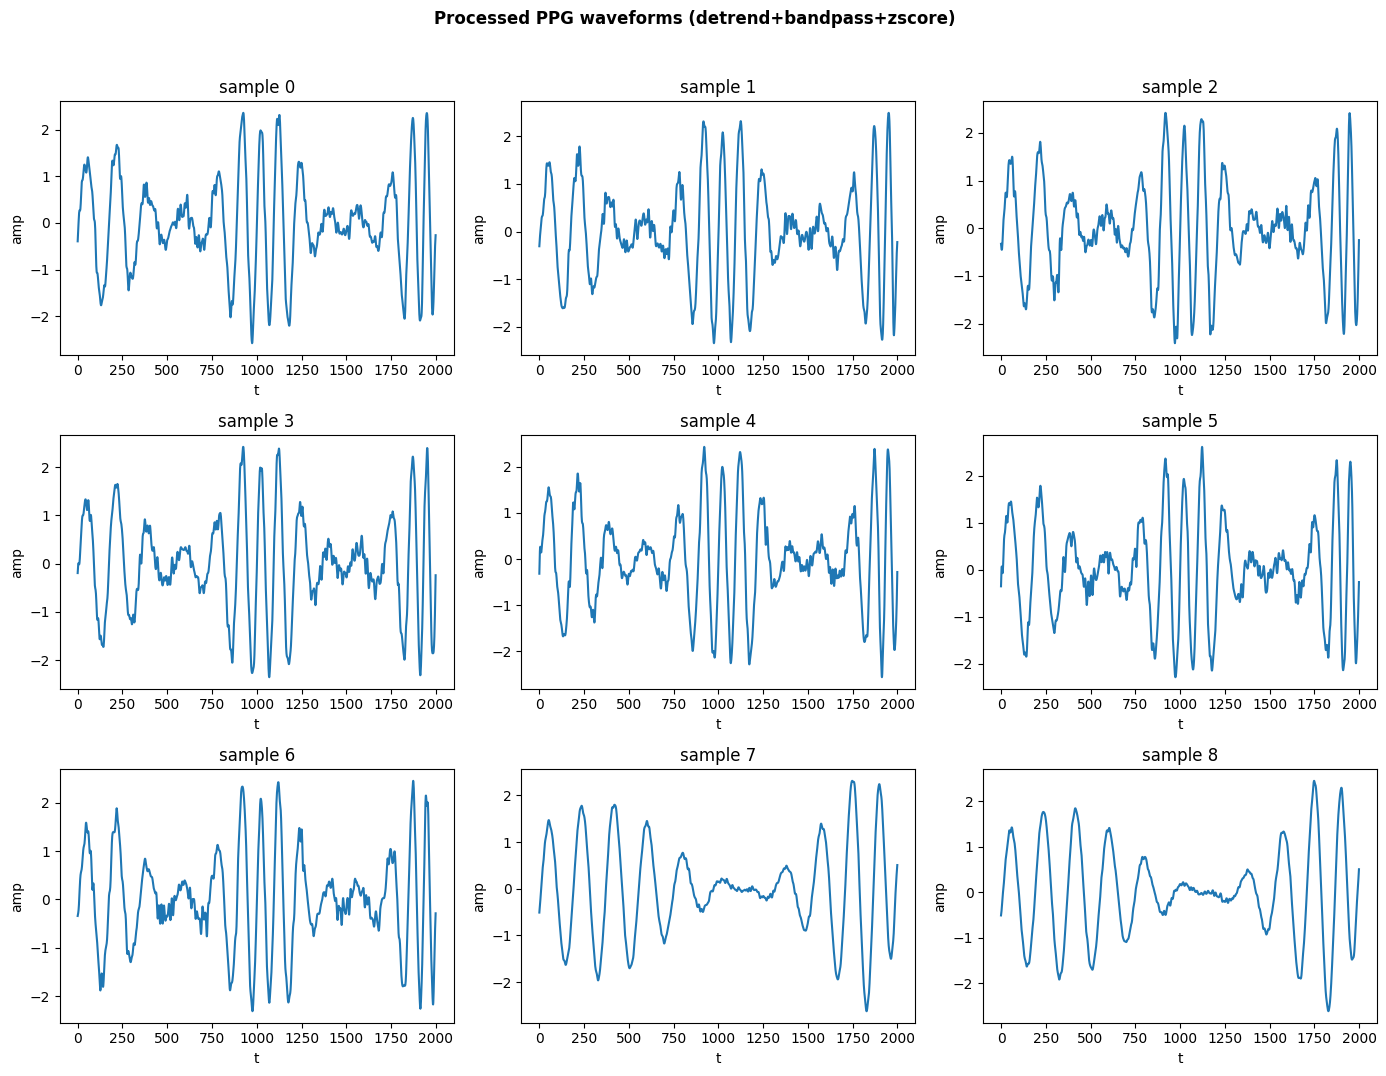

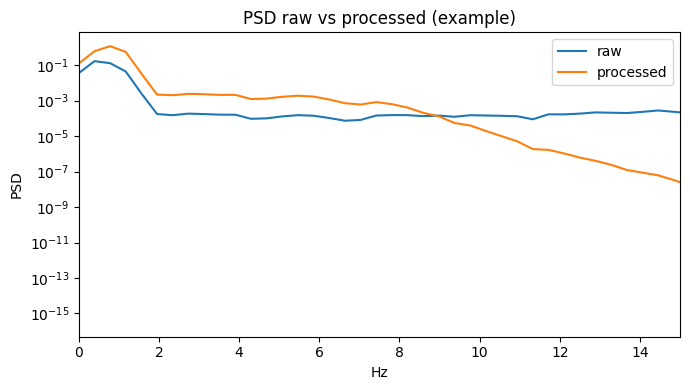

In [5]:
plot_wave_grid(X_pp, "Processed PPG waveforms (detrend+bandpass+zscore)", os.path.join(FIG_DIR_AFTER, "waveforms_processed_grid.png"))

# PSD comparison (average)
f1, p1 = welch(X_raw[0], fs=FS, nperseg=256)
f2, p2 = welch(X_pp[0], fs=FS, nperseg=256)

plt.figure(figsize=(7,4))
plt.semilogy(f1, p1, label="raw")
plt.semilogy(f2, p2, label="processed")
plt.xlim(0, 15)
plt.xlabel("Hz"); plt.ylabel("PSD")
plt.title("PSD raw vs processed (example)")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "psd_raw_vs_processed.png"), dpi=150)
plt.show()


In [6]:
# Sequence preparation for training
DOWNSAMPLE = 4
X_seq = X_pp[:, ::DOWNSAMPLE]
print("Sequence length:", X_seq.shape[1])

X_seq = X_seq[..., None]

# Train and validation split
from sklearn.model_selection import train_test_split
import numpy as np

X_tr, X_val = train_test_split(X_seq, test_size=0.2, random_state=42)

def add_noise_seq(x, std=0.15):
    noisy = x + np.random.normal(0, std, size=x.shape)
    noisy = np.nan_to_num(noisy, nan=0.0, posinf=0.0, neginf=0.0)
    return np.clip(noisy, -8, 8)

Sequence length: 500


In [7]:
# Building LSTM DAE
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, RepeatVector, TimeDistributed, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN

T = X_tr.shape[1]

inp = Input(shape=(T, 1), name="ppg_input")

# Encoder
x = LSTM(128, return_sequences=True)(inp)
x = Dropout(0.2)(x)
x = LSTM(64, return_sequences=False)(x)
x = Dropout(0.2)(x)

# 32-d embedding
emb = Dense(32, activation="relu", name="ppg_embedding")(x)

# Decoder
z = RepeatVector(T)(emb)
z = LSTM(64, return_sequences=True)(z)
z = Dropout(0.2)(z)
z = LSTM(128, return_sequences=True)(z)

out = TimeDistributed(Dense(1), name="reconstruction")(z)

auto = Model(inp, out, name="ppg_lstm_autoencoder")
encoder = Model(inp, emb, name="ppg_lstm_encoder")

auto.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss="mse")
auto.summary()

Model: "ppg_lstm_autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ ppg_input (InputLayer)          │ (None, 500, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 500, 128)       │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 500, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ ppg_embedding (Dense)           │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 500, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 500, 64)        │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 500, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 500, 128)       │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reconstruction                  │ (None, 500, 1)         │           129 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 241,825 (944.63 KB)

 Trainable params: 241,825 (944.63 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Training
history = auto.fit(
    add_noise_seq(X_tr, 0.15), X_tr,
    validation_data=(add_noise_seq(X_val, 0.15), X_val),
    epochs=100,
    batch_size=32,
    callbacks=[
        TerminateOnNaN(),
        EarlyStopping(patience=15, restore_best_weights=True),
        ReduceLROnPlateau(patience=6, factor=0.5)
    ],
    verbose=1
)

Epoch 1/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 198s 3s/step - loss: 0.9844 - val_loss: 0.9759 - learning_rate: 0.0010
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 171s 3s/step - loss: 0.8780 - val_loss: 0.7120 - learning_rate: 0.0010
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - loss: 0.6744 - val_loss: 0.5926 - learning_rate: 0.0010
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 164s 3s/step - loss: 0.6240 - val_loss: 0.5885 - learning_rate: 0.0010
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - loss: 0.5934 - val_loss: 0.5753 - learning_rate: 0.0010
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - loss: 0.5878 - val_loss: 0.5773 - learning_rate: 0.0010
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 188s 3s/step - loss: 0.5886 - val_loss: 0.5696 - learning_rate: 0.0010
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 294s 5s/step - loss: 0.5768 - val_loss: 0.5488 - learning_rate: 0.0010
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 262s 4s/step - loss: 0.5692 - val_loss: 0.5641 - learning_rate: 0.0010
Epoch 10/1

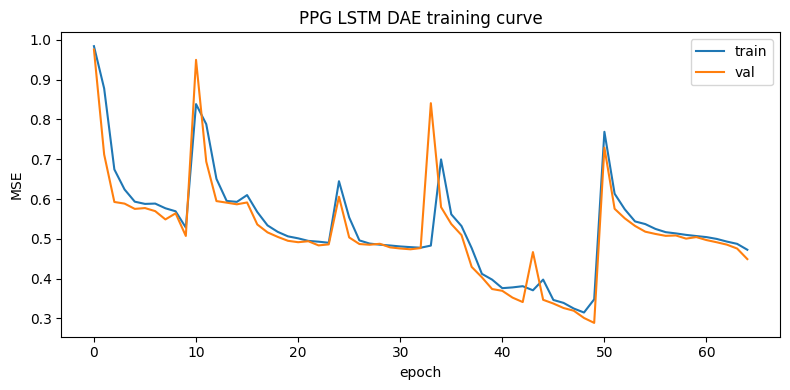

In [10]:
# Loss curve
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.title("PPG LSTM DAE training curve")
plt.xlabel("epoch"); plt.ylabel("MSE")
plt.legend()
plt.tight_layout()
plt.savefig("../reports/figures/ppg_training/ppg_lstm_dae_loss_curve.png", dpi=150)
plt.show()

In [13]:
# Embedding extraction
ppg_emb = encoder.predict(X_seq, verbose=0)
print("Embedding shape:", ppg_emb.shape)  # (N, 32)

emb_cols = [f"ppg_emb_{i}" for i in range(32)]
df_emb = pd.DataFrame(ppg_emb, columns=emb_cols)

df_out = pd.concat([df_raw.reset_index(drop=True), df_emb], axis=1)

# Optional keep Label for debugging
if "Label" in df_raw.columns:
    df_out["Label"] = df_raw["Label"].values

df_out.to_csv("../data/processed/ppg_with_embeddings.csv", index=False)
print(" Saved: data/processed/ppg_with_embeddings.csv")

Embedding shape: (2576, 32)
 Saved: data/processed/ppg_with_embeddings.csv


In [15]:
# Save artifacts
import os, json, joblib
from datetime import datetime

version = datetime.now().strftime("%Y%m%d_%H%M%S")
ART_DIR = f"../models_artifacts/ppg_lstm_encoder/{version}"
os.makedirs(ART_DIR, exist_ok=True)

encoder.save(os.path.join(ART_DIR, "encoder.h5"))
auto.save(os.path.join(ART_DIR, "autoencoder.h5"))

with open(os.path.join(ART_DIR, "preprocess.json"), "w") as f:
    json.dump({"fs": FS, "bandpass_low": LOW, "bandpass_high": HIGH,
               "order": 4, "downsample": DOWNSAMPLE}, f, indent=2)

with open(os.path.join(ART_DIR, "metadata.json"), "w") as f:
    json.dump({"embedding_dim": 32, "seq_len": int(T)}, f, indent=2)

print(" Saved artifacts to:", ART_DIR)

 Saved artifacts to: ../models_artifacts/ppg_lstm_encoder/20260220_232539
